In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input
from Single_PTR import Single_PTR
from PTR import PTR
from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp
from EstimatingLipschitz import Lipschitz
from LMI import Q_update

(CVXPY) Sep 01 02:33:16 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)")


In [4]:
ix = 3
iu = 2
iw = 2
iq = 2
ip = 2
N = 30
tf = 3
delT = tf/N

In [5]:
# time-invariant matrices
C = np.array([[0,0,1],[0,0,0]])
D = np.array([[0,0],[1,0]])
E = np.array([[1,0],[0,1],[0,0]])
G = np.zeros((iq,iw))

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
# H1 = get_H_obs(0.75,1.5)
H1 = get_H_obs(1.2,2.3)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
# H2 = get_H_obs(0.75,1.5)
H2 = get_H_obs(1.2,2.3)
c_list.append(c2)
H_list.append(H2)

In [7]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
Qf = np.diag([0.5**2,0.5**2,np.deg2rad(20)**2])*1.5



myModel = UnicycleModel.unicycle('Hello',ix,iu,iw,'numeric_central')
myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

traj_solver= PTR('unicycle',N,tf,30,myModel,myCost,myConst,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,verbosity=True)
_,_,x0,u0,total_num_iter,flag_boundary,_,_,_ = traj_solver.run(x0,u0,xi,xf)


iteration   total_cost        cost        ||vc||     ||tr||       reduction   w_tr        bounary
1           7197.823          89.176      6.2         90.9        -6.2e+03    10.000      0(5.3)
2           3572.517          225.696     1.56        179         3.63e+03    10.000      0(3.21)
3           639.851           408.802     3.14e-10    23.1        2.93e+03    10.000      0(4.98)
4           463.000           226.271     5.27e-10    23.7        177         10.000      0(3.46)
5           516.673           420.395     4.86e-10    9.63        -53.7       10.000      0(2.13)
6           346.313           329.781     3.68e-10    1.65        170         10.000      0(0.708)
7           380.081           377.420     8.44e-10    0.266       -33.8       10.000      0(0.0341)
8           377.584           377.537     1.16e-09    0.00466     2.5         10.000      1(0.000164)
9           377.516           377.507     6.89e-10    0.0009      0.0676      10.000      1(1.35e-05)
10        

In [8]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

In [9]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.75,1.5)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
H2 = get_H_obs(0.75,1.5)
c_list.append(c2)
H_list.append(H2)

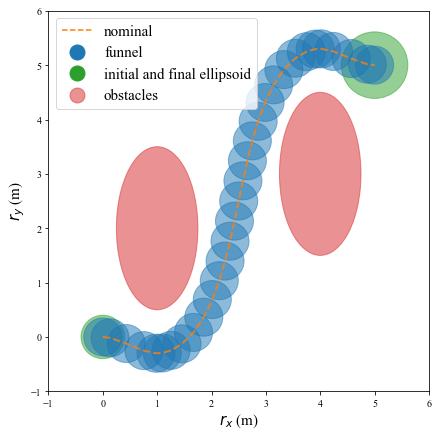

In [10]:
plt.figure(1,figsize=(7,7))
plt.rcParams["font.family"] = "Times New Roman"
plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)

plt.savefig('../images/first_iteration/overestimation.pdf')
# plt.close()

In [ ]:
myModel = UnicycleModel.unicycle('Hello',ix,iu,iw,'numeric_central')
myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

traj_solver= PTR('unicycle',N,tf,30,myModel,myCost,myConst,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,verbosity=True)
_,_,x0,u0,total_num_iter,flag_boundary,_,_,_ = traj_solver.run(x0,u0,xi,xf)

In [ ]:
plt.figure(1,figsize=(7,7))
plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig('../images/first_iteration/underestiatmion.pdf')
# plt.close()